In [1]:
# Transfer learning: take the patterns another model has learned from another problem
# and use them for our own problem.

# Examples:
# Computer vision models leaned from large image dataset such as ImageNet
# Large Language Models trained from large amount of text to learn representation of language

# Across a wide range of datasets, even if the downstream data of interest appears to only be weakly
# related to the data used for pre-training, transfer learning remains the best available option.

In [2]:
# Places to find pretrained models:
# 
# PyTorch libraries
# e.g., torchvision.models, torchtext.models, torchaudio.models, torchrec.models
#
# HuggingFace Hub
# https://huggingface.co/models
# https://huggingface.co/datasets

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.0
torchvision version: 0.15.1


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

In [5]:
from src_05_modular import data_setup, engine, utils

In [6]:
device = utils.get_device()
device

'mps'

In [7]:
# Setup data

In [8]:
import pathlib

In [9]:
data_path = pathlib.Path("data/")
image_path = data_path/"pizza_steak_sushi"

In [10]:
train_dir = image_path/"train"
test_dir = image_path/"test"

## Datasets and DataLoaders

### 1. Create Transforms for torchvision.models: manual creation

In [11]:
# When using a pre-trained model, your custom data must be prepared the same way 
# as the original training data that went into the model.

In [12]:
# Specifically, computer vision models in torchvision expect input images normalized in the following way:
# * Mini-batches of three-channel RGB images of shape 3*Height*Width, with H, W at least 224.
# * Images have to be loaded in to a range of [0, 1], and then normalize using
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

# The above steps in PyTorch code are:
# 1. Mini-batches of size [batch_size, 3, height, width], using
# torchvision.transforms.Resize() and then torch.utils.data.DataLoader() to create batches
# 2. Values between 0 and 1, using
# torchvision.transforms.ToTensor()
# 3. Normalize using
# torchvision.transforms.Normalize(mean=, std=)

In [13]:
manual_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [14]:
batch_size = 64

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=batch_size
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x105e65a30>,
 ['pizza', 'steak', 'sushi'])

### 2. Create Transforms for torchvision.models: auto creation

In [16]:
# As of torchvision v0.13+, auto transform creation feature has been added.
# Say you'd like to use the following model: ModelABC, you can obtain
# weights = torchvision.models.ModelABC.DEFAULT 
# (DEFAULT indicates the best available weights for the chosen model architecture)

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
# Now, access the transforms associated with the above model's weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
# Same way for train/test dataloaders

In [20]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=batch_size
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x150ba8a90>,
 ['pizza', 'steak', 'sushi'])

## Getting pretrained model

In [21]:
# Transfer learning: take an already well-performing model on a problem-space similar to yours 
# and then customizing it to your case.

In [22]:
# Computer vision model architectures available in torchvision:

# ResNet
# torchvision.models.resnet18()
# torchvision.models.resnet50()

# VGG
# torchvision.models.vgg16()

# EfficientNet
# torchvision.models.efficientnet_b0()
# torchvision.models.efficientnet_b1()

# VisionTransformer (ViT)
# torchvision.models.vit_b_16()
# torchvision.models.vit_b_32()

# ConvNeXt
# torchvision.models.convnext_tiny()
# torchvision.models.convnext_small()

In [23]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [24]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
next(model.parameters()).device

device(type='mps', index=0)

In [25]:
#model

In [26]:
# Efficientnet_b0 comes in three main parts
# 1. Feature extractor: features
# A collection of conv layers and activation layers to learn representation of vision data.
# The base layers of the model learn the different features of images.
# 2. avgpool
# Takes the avg of the output of "features" layers and turns it into feature vector.
# 3. classifier
# Map feature vectors to class probabilities.

### Get summary of model using torchinfo.summary()

In [27]:
# Required input for torchinfo.summary():
# model:
# input_size: (batch_size, n_Channels=3, H=224, W=224). Diff model family may use diff numbers
# col_names: the various info columns you want to see about the model
# col_width: how wide the display of model info would be
# row_settings: what features to show in a row

In [28]:
import torchinfo

In [29]:
next(model.parameters()).device

device(type='mps', index=0)

In [30]:
summary0 = torchinfo.summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', "trainable"],
    col_width=16,
    row_settings=['var_names']
)

/Users/czq/miniforge3/envs/torch/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/czq/miniforge3/envs/torch/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [31]:
type(summary0)

torchinfo.model_statistics.ModelStatistics

In [32]:
summary0

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]       --               True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --               True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --               True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864              True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64               True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --               --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --               True
│    │    └─MBConv (0)                   

### a. Freeze the base model and change the output layer

In [33]:
# Freeze layers in the "features" section by setting requires_grad = False.
# Then PyTorch doesn't track gradient updates and so the parameters won't be changed.
# That is, a parameter with requires_grad = False is untrainable/frozen in place.

In [34]:
# Freeze all base layers in model.features

### !!! Problem: whenver torchinfo.summary() is called, model is put back from GPU to CPU

In [35]:
next(model.parameters()).device

device(type='cpu')

In [36]:
model = model.to(device)

In [37]:
next(model.parameters()).device

device(type='mps', index=0)

In [38]:
for param in model.features.parameters():
    param.requires_grad = False

In [39]:
next(model.parameters()).device

device(type='mps', index=0)

### b. Adjust output layer of the "classifier" portion of the model

In [40]:
torch.manual_seed(123)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [41]:
next(model.parameters()).device, next(model.classifier.parameters()).device

(device(type='mps', index=0), device(type='mps', index=0))

In [42]:
summary1 = torchinfo.summary(
    model,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', "num_params", "trainable"],
    col_width=32,
    row_settings=['var_names']
)

In [43]:
summary1 
# Notice:
# Huge drop in number of trainable parameters, from 5M to 4K
# Output layer: IN [32, 1280] -> OUT [32, 3]

Layer (type (var_name))                                      Input Shape                      Output Shape                     Param #                          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]                [32, 3]                          --                               Partial
├─Sequential (features)                                      [32, 3, 224, 224]                [32, 1280, 7, 7]                 --                               False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]                [32, 32, 112, 112]               --                               False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]                [32, 32, 112, 112]               (864)                            False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]               [32, 32, 112, 112]               (64)                             Fals

## Train model
Here, only train the params in "classifier" portion with all the other params frozen

In [44]:
next(model.parameters()).device

device(type='cpu')

In [45]:
model = model.to(device)

In [46]:
next(model.parameters()).device

device(type='mps', index=0)

In [47]:
# Define loss function and optimizer

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
from timeit import default_timer as timer 

In [50]:
torch.manual_seed(123)

start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss: 1.0840, Train acc: 0.3751 |  Test loss: 0.9800, Test acc: 0.5852
Epoch 2: Train loss: 0.9239, Train acc: 0.6581 |  Test loss: 0.8957, Test acc: 0.6385
Epoch 3: Train loss: 0.8135, Train acc: 0.7211 |  Test loss: 0.7359, Test acc: 0.8075
Epoch 4: Train loss: 0.7078, Train acc: 0.8381 |  Test loss: 0.6340, Test acc: 0.8984
Epoch 5: Train loss: 0.6036, Train acc: 0.9028 |  Test loss: 0.6029, Test acc: 0.7933
Epoch 6: Train loss: 0.5494, Train acc: 0.9109 |  Test loss: 0.6071, Test acc: 0.8232
Epoch 7: Train loss: 0.4937, Train acc: 0.9226 |  Test loss: 0.4956, Test acc: 0.9297
Epoch 8: Train loss: 0.4242, Train acc: 0.9492 |  Test loss: 0.5144, Test acc: 0.9297
Epoch 9: Train loss: 0.4253, Train acc: 0.9416 |  Test loss: 0.5301, Test acc: 0.8388
Epoch 10: Train loss: 0.3749, Train acc: 0.9455 |  Test loss: 0.3794, Test acc: 0.9297
[INFO] Total training time: 12.440 seconds.


## Evaluate model

In [52]:
import helper_functions

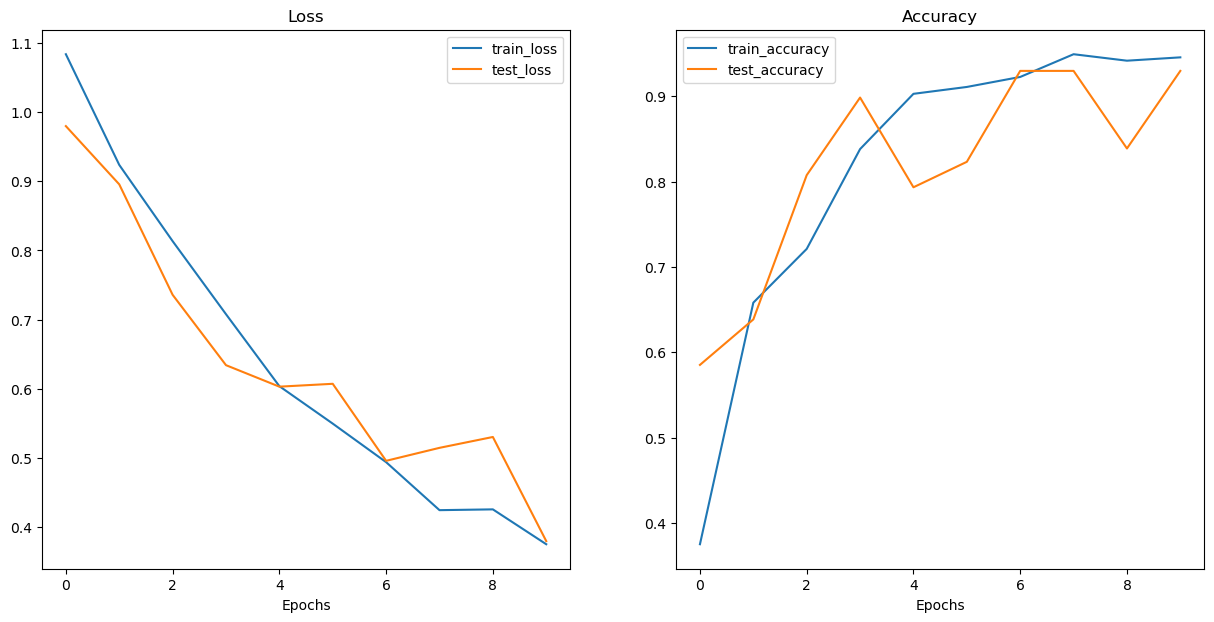

In [53]:
helper_functions.plot_loss_curves(results)

## Inference

In [54]:
# Ensure four "the same"s
# The same shape
# The same datatype
# The same device
# The same transformations

In [55]:
from typing import List, Tuple
from PIL import Image

In [69]:
def predict_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int]=(224, 224),
    transform: torchvision.transforms=None,
    device:torch.device=device
):
    
    img = Image.open(image_path)
    
    if transform:
        image_transform = transform
    else: # i.e. transform = None
        image_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    # Predict on image
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        # .unsqueeze(): add the batch dimension, i.e. [Ch, H, W] -> [1, Ch, H, W] 
        transformed_image = image_transform(img).unsqueeze(dim=0)
        
        pred = model(transformed_image.to(device))
        pred_img_class_proba = torch.softmax(pred, dim=1)
        pred_img_class = torch.argmax(pred_img_class_proba, dim=1)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred Class: {class_names[pred_img_class]} | Proba: {pred_img_class_proba.max():.3f}")
    plt.axis(False);    

In [57]:
# Look at a few random pictures

In [58]:
import random

In [63]:
n_images = 5

test_images = list(pathlib.Path(test_dir).glob("*/*.jpg"))
test_images = random.sample(test_images, k=n_images)
test_images

[PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg')]

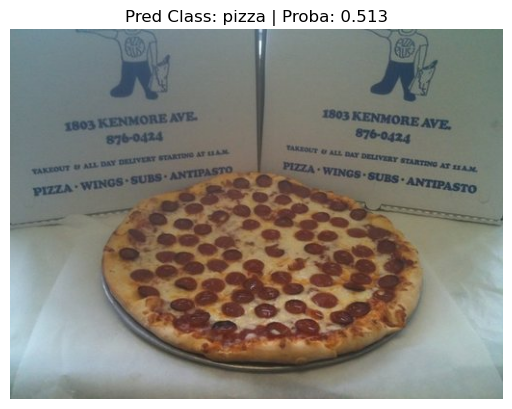

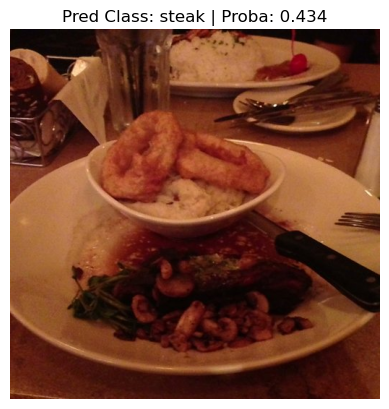

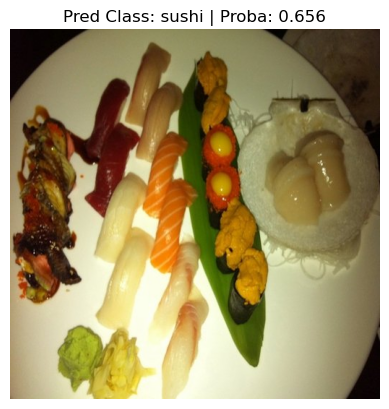

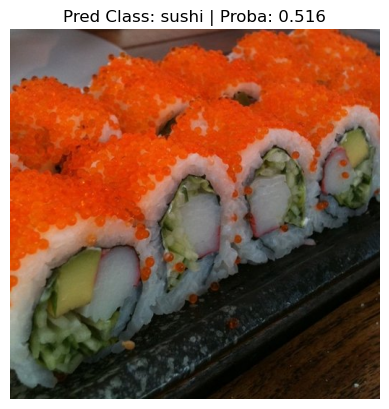

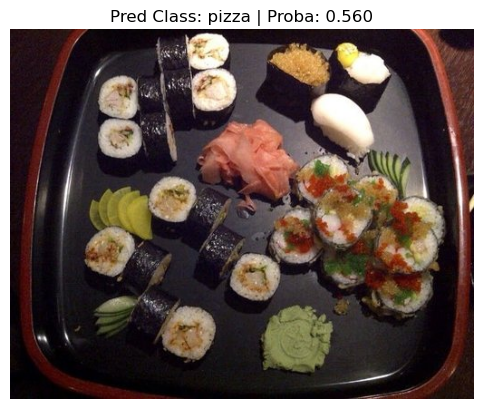

In [70]:
for img in test_images:
    predict_and_plot_image(model=model, image_path=img, class_names=class_names)